In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ✅ Step 1: Install YOLOv8
!pip install ultralytics --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.1 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import cv2

# Update this to your dataset folder
dataset_dir = "/kaggle/input/red-traffic-violation"

splits = ['train', 'valid', 'test']
image_exts = ['.jpg', '.jpeg', '.png']

errors = {
    "missing_label": [],
    "missing_image": [],
    "corrupt_image": [],
    "empty_labels": [],
    "invalid_labels": [],
}
class_counts = {}

def check_label_format(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        if len(lines) == 0:
            errors['empty_labels'].append(label_path)
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                errors['invalid_labels'].append(label_path)
                return
            try:
                cls, x, y, w, h = map(float, parts)
                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                    errors['invalid_labels'].append(label_path)
            except ValueError:
                errors['invalid_labels'].append(label_path)

            class_id = int(cls)
            class_counts[class_id] = class_counts.get(class_id, 0) + 1

def is_image_corrupt(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None or img.shape[0] == 0 or img.shape[1] == 0:
            return True
        return False
    except:
        return True

for split in splits:
    image_dir = os.path.join(dataset_dir, split, "images")
    label_dir = os.path.join(dataset_dir, split, "labels")

    for img_file in os.listdir(image_dir):
        name, ext = os.path.splitext(img_file)
        if ext.lower() not in image_exts:
            continue

        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, name + ".txt")

        # Check for label file
        if not os.path.exists(label_path):
            errors['missing_label'].append(img_file)
        else:
            check_label_format(label_path)

        # Check image
        if is_image_corrupt(img_path):
            errors['corrupt_image'].append(img_file)

    for label_file in os.listdir(label_dir):
        name = os.path.splitext(label_file)[0]
        img_found = False
        for ext in image_exts:
            if os.path.exists(os.path.join(image_dir, name + ext)):
                img_found = True
                break
        if not img_found:
            errors['missing_image'].append(label_file)

# Print summary
print("\n🧹 Dataset Validation Summary:")
for k, v in errors.items():
    print(f"- {k.replace('_', ' ').title()}: {len(v)}")

print("\n📊 Class Distribution:")
for cls_id, count in sorted(class_counts.items()):
    print(f"Class {cls_id}: {count} labels")

# Optional: Save errors to file
with open("errors_summary.txt", "w") as f:
    for k, v in errors.items():
        f.write(f"{k.upper()} ({len(v)}):\n")
        f.writelines([f"{item}\n" for item in v])
        f.write("\n")



🧹 Dataset Validation Summary:
- Missing Label: 0
- Missing Image: 0
- Corrupt Image: 0
- Empty Labels: 4
- Invalid Labels: 0

📊 Class Distribution:
Class 0: 500 labels
Class 1: 500 labels
Class 2: 500 labels
Class 3: 500 labels


In [5]:
import os
import shutil

# Step 1: Copy dataset from input to working directory
input_path = "/kaggle/input/red-traffic-violation"  # your dataset name
output_path = "/kaggle/working/red-traffic-violation"

# Copy recursively
if not os.path.exists(output_path):
    shutil.copytree(input_path, output_path)
    print("✅ Dataset copied to working directory.")

# Step 2: Clean empty label files
delete_images_too = False  # Optional: Set to True if you want to remove images too
empty_count = 0

for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(output_path, split, "labels")
    image_dir = os.path.join(output_path, split, "images")

    for file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, file)
        if os.path.isfile(label_path) and os.stat(label_path).st_size == 0:
            empty_count += 1
            os.remove(label_path)
            print(f"🗑️ Removed empty label: {file}")
            
            if delete_images_too:
                img_name = os.path.splitext(file)[0]
                for ext in [".jpg", ".jpeg", ".png"]:
                    img_path = os.path.join(image_dir, img_name + ext)
                    if os.path.exists(img_path):
                        os.remove(img_path)
                        print(f"🗑️ Removed image: {img_name + ext}")

print(f"\n✅ Cleaned {empty_count} empty label files from working dataset.")


✅ Dataset copied to working directory.
🗑️ Removed empty label: chrome_UTpN11OlKW_png.rf.56d9bd707a84a9242462a190e2178bbd.txt
🗑️ Removed empty label: chrome_mg7tsvMq3n_png.rf.36d5d5ff513679e8d91c97d5ede5f56c.txt
🗑️ Removed empty label: cb86f4f1f5d61f5e_jpg.rf.83326de4b856ab9be389ac4533f05d8d.txt
🗑️ Removed empty label: chrome_LESjsr0iFB_png_jpg.rf.d97cf148195a07d929a805001f93551f.txt

✅ Cleaned 4 empty label files from working dataset.


In [9]:
updated_yaml = """
train: /kaggle/input/red-traffic-violation/train/images
val: /kaggle/input/red-traffic-violation/valid/images
test: /kaggle/input/red-traffic-violation/test/images

nc: 4
names: ['green_light', 'red_light', 'vehicle', 'yellow_light']
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(updated_yaml)


In [10]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')  # or yolov8s.yaml for better accuracy

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
model.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    name='signal_violation_yolov8',
    project='/kaggle/working'
)

Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=signal_violation_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

100%|██████████| 755k/755k [00:00<00:00, 3.80MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.2 ms, read: 65.4±41.1 MB/s, size: 34.9 KB)


train: Scanning /kaggle/input/red-traffic-violation/train/labels... 985 images, 4 backgrounds, 0 corrupt: 100%|██████████| 985/985 [00:00<00:00, 997.20it/s] 

WARNING ⚠️ train: Cache directory /kaggle/input/red-traffic-violation/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.1±1.5 ms, read: 59.0±60.3 MB/s, size: 35.2 KB)


val: Scanning /kaggle/input/red-traffic-violation/valid/labels... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<00:00, 552.95it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/red-traffic-violation/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/signal_violation_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/signal_violation_yolov8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.18G      3.762      5.024      4.177          1        640: 100%|██████████| 124/124 [00:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]

                   all        303        421    0.00112      0.166    0.00101   0.000351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.83G      3.084      4.199      3.585          1        640: 100%|██████████| 124/124 [00:15<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


                   all        303        421      0.404      0.178     0.0889     0.0323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.84G      2.699      3.658      3.102          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.78it/s]


                   all        303        421       0.48      0.221      0.202     0.0773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.86G      2.529      3.272      2.866          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.05it/s]


                   all        303        421      0.323      0.267      0.209     0.0933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.88G      2.387      3.029       2.68          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.68it/s]


                   all        303        421      0.485      0.336      0.287      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.89G      2.288      2.797      2.553          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]

                   all        303        421      0.663      0.339       0.39      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.91G       2.13      2.571      2.438          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.01it/s]

                   all        303        421       0.45      0.415      0.416      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.93G      2.022      2.406      2.295          4        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


                   all        303        421      0.786      0.451      0.524      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.95G      1.908      2.223      2.202          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


                   all        303        421      0.444      0.518      0.432      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.96G       1.83      2.129      2.137          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]

                   all        303        421      0.702      0.539      0.626      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.98G      1.759      1.988      2.074          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]

                   all        303        421      0.638      0.562      0.614      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         2G      1.714      1.967       2.03          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]

                   all        303        421      0.685      0.563      0.607      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.02G      1.685      1.881      1.977          7        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.03it/s]


                   all        303        421      0.698      0.633      0.664       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.03G      1.647      1.814      1.928          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.92it/s]

                   all        303        421       0.67      0.607      0.652      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.05G      1.614      1.773      1.912          4        640: 100%|██████████| 124/124 [00:14<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]

                   all        303        421      0.714      0.639      0.692      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.07G      1.567      1.739      1.876          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.59it/s]


                   all        303        421      0.706      0.632      0.678      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.08G      1.554      1.681      1.845          6        640: 100%|██████████| 124/124 [00:14<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]

                   all        303        421      0.755      0.667      0.711      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.1G      1.524      1.679      1.835          5        640: 100%|██████████| 124/124 [00:14<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


                   all        303        421      0.745      0.659       0.72      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.12G      1.497      1.576      1.788          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.88it/s]

                   all        303        421      0.713      0.674      0.726      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.13G      1.463      1.568      1.753          4        640: 100%|██████████| 124/124 [00:14<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.97it/s]


                   all        303        421      0.766      0.688       0.75      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.15G      1.421       1.51       1.72          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]

                   all        303        421      0.762      0.681      0.742      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.17G      1.412      1.482      1.713          4        640: 100%|██████████| 124/124 [00:14<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]

                   all        303        421      0.739      0.731      0.771      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.19G      1.396      1.446      1.681          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.21it/s]

                   all        303        421      0.808      0.714      0.788      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.2G      1.389      1.441      1.657          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]

                   all        303        421      0.774      0.734      0.792      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.22G      1.394      1.422      1.664          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]

                   all        303        421      0.813       0.76      0.805      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.24G      1.337      1.353      1.636          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.30it/s]

                   all        303        421      0.796      0.758      0.787      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.25G      1.314      1.326        1.6          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]

                   all        303        421      0.825      0.759       0.83      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.27G      1.303      1.306      1.591          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.42it/s]

                   all        303        421      0.839      0.745      0.822      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.29G      1.292      1.292        1.6          5        640: 100%|██████████| 124/124 [00:14<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]

                   all        303        421      0.816      0.747      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.3G      1.294      1.311      1.585          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.77it/s]


                   all        303        421      0.851       0.76      0.827      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.32G      1.292      1.282      1.587          5        640: 100%|██████████| 124/124 [00:14<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


                   all        303        421      0.893      0.736      0.841      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.34G      1.258      1.267      1.548          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.58it/s]

                   all        303        421      0.849      0.756      0.835      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.36G       1.23      1.251      1.527          0        640: 100%|██████████| 124/124 [00:14<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]

                   all        303        421      0.864      0.766       0.84      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G      1.233      1.203      1.522          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]

                   all        303        421      0.845      0.758      0.829      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.39G      1.218      1.213      1.502          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]

                   all        303        421      0.868      0.784      0.836      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.41G      1.214      1.175      1.512          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]

                   all        303        421      0.871      0.783      0.856      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.42G      1.218      1.185      1.496          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]

                   all        303        421      0.845        0.8      0.849      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.44G      1.182      1.156       1.48          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]

                   all        303        421      0.878      0.781      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.46G      1.189      1.127      1.469          6        640: 100%|██████████| 124/124 [00:14<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.43it/s]

                   all        303        421       0.89      0.781      0.856      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.47G      1.178      1.102      1.476          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.73it/s]

                   all        303        421      0.887      0.809      0.873      0.592


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.49G        1.1       1.01      1.404          1        640: 100%|██████████| 124/124 [00:15<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.56it/s]

                   all        303        421      0.825      0.803      0.847      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.51G      1.078     0.9433      1.406          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]

                   all        303        421      0.859        0.8      0.865      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.53G      1.069     0.9371      1.391          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.90it/s]

                   all        303        421      0.893      0.801      0.871      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.54G       1.05      0.888      1.368          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.28it/s]

                   all        303        421      0.915      0.776      0.882      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.56G      1.034     0.8812      1.371          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.39it/s]

                   all        303        421      0.899      0.811       0.89      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.58G      1.016     0.8943      1.357          3        640: 100%|██████████| 124/124 [00:14<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]

                   all        303        421      0.904      0.817      0.887      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.6G      1.008     0.8534      1.331          2        640: 100%|██████████| 124/124 [00:14<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]

                   all        303        421      0.915      0.807      0.888      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.61G      1.006     0.8324      1.329          4        640: 100%|██████████| 124/124 [00:14<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]

                   all        303        421      0.915      0.818      0.892      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.63G      0.968     0.8305      1.308          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]

                   all        303        421       0.91      0.823      0.891      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.65G     0.9807     0.8298      1.328          1        640: 100%|██████████| 124/124 [00:14<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.42it/s]

                   all        303        421      0.916      0.817      0.891      0.629



50 epochs completed in 0.237 hours.
Optimizer stripped from /kaggle/working/signal_violation_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/signal_violation_yolov8/weights/best.pt, 6.2MB

Validating /kaggle/working/signal_violation_yolov8/weights/best.pt...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        303        421      0.916      0.819      0.891      0.629
           green_light         70        100      0.955      0.851       0.92      0.673
             red_light         66        100      0.873      0.826      0.892      0.597
               vehicle         88        121      0.904      0.697      0.825      0.586
          yellow_light         84        100      0.933        0.9      0.927      0.659
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/signal_violation_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c980ce27850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [13]:
# Load trained model
model = YOLO('/kaggle/working/signal_violation_yolov8/weights/best.pt')

# Save again to a different location
model.save('/kaggle/working/violation_model.pt')

In [14]:
from ultralytics import YOLO

# Load trained model (update path as needed)
model = YOLO('/kaggle/working/signal_violation_yolov8/weights/best.pt')


In [15]:
metrics = model.val(data='/kaggle/working/data.yaml')  

Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 338.2±607.6 MB/s, size: 258.8 KB)


val: Scanning /kaggle/input/red-traffic-violation/valid/labels... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<00:00, 760.23it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/red-traffic-violation/valid is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        303        421      0.913      0.814      0.891      0.629
           green_light         70        100      0.944       0.85       0.92      0.672
             red_light         66        100      0.871       0.81      0.892      0.597
               vehicle         88        121      0.904      0.696      0.825      0.585
          yellow_light         84        100      0.934        0.9      0.927      0.661
Speed: 0.7ms preprocess, 5.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val



image 1/1 /kaggle/input/red-traffic-violation/test/images/Screen-Shot-2022-04-14-at-12-58-47-AM_png_jpg.rf.542b968162355c3f47134ffc8c233984.jpg: 640x640 2 vehicles, 6.1ms
Speed: 3.5ms preprocess, 6.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /kaggle/input/red-traffic-violation/test/images/chrome_78k2ZgSejY_png_jpg.rf.14077b45b3db0c98a1cb5804a6269a04.jpg: 416x640 2 green_lights, 36.9ms
Speed: 2.0ms preprocess, 36.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


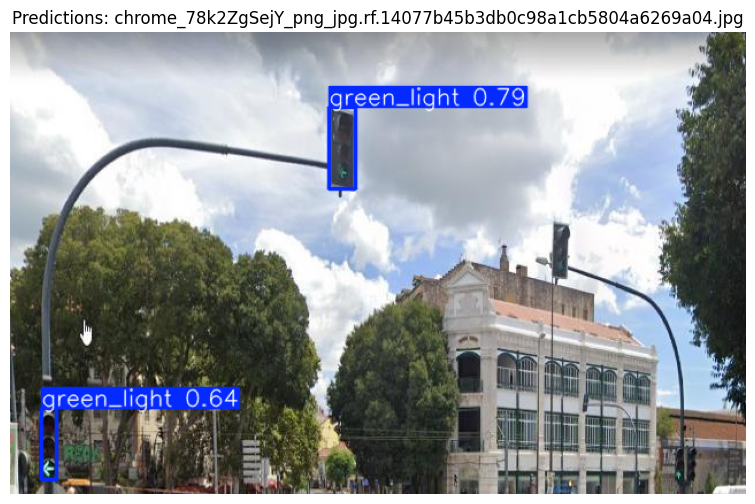


image 1/1 /kaggle/input/red-traffic-violation/test/images/08db315d178d0e00_jpg.rf.826d377fe1da9c3dfc1901bd7323d7a1.jpg: 640x512 1 red_light, 33.8ms
Speed: 1.5ms preprocess, 33.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


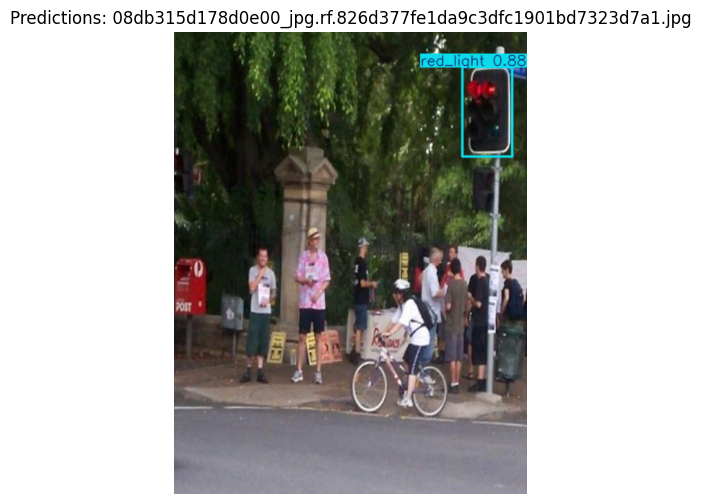


image 1/1 /kaggle/input/red-traffic-violation/test/images/000036_jpg.rf.a2c2397219c1bfe69ca2064cf2f755c7.jpg: 384x640 2 yellow_lights, 34.5ms
Speed: 1.8ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


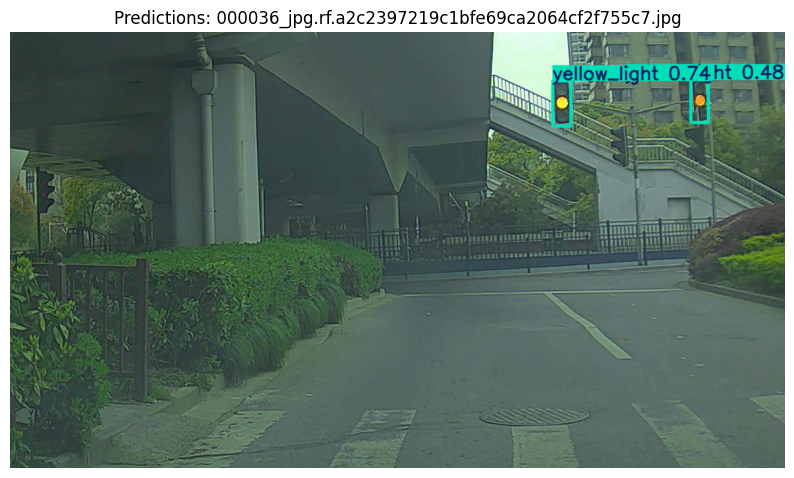


image 1/1 /kaggle/input/red-traffic-violation/test/images/08c2332b93bcf351_jpg.rf.c38bc08a3f13812e64f7437713c61100.jpg: 640x640 2 red_lights, 1 yellow_light, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


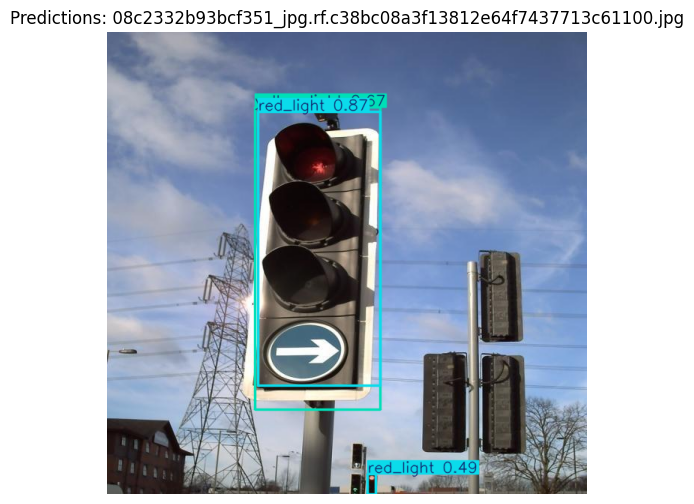

In [24]:
# Correct folder path to test images
image_folder = '/kaggle/input/red-traffic-violation/test/images'
image_paths = glob(os.path.join(image_folder, '*.jpg'))

# Show predictions on first 5 images
for img_path in image_paths[:5]:
    results = model.predict(img_path, conf=0.3)
    annotated = results[0].plot()

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

In [26]:
import os

# See all subdirectories
for root, dirs, files in os.walk("/kaggle/working"):
    for name in files:
        if name.endswith(".pt"):
            print(os.path.join(root, name))


/kaggle/working/violation_model.pt
/kaggle/working/best.pt
/kaggle/working/yolo11n.pt
/kaggle/working/signal_violation_yolov8/weights/best.pt
/kaggle/working/signal_violation_yolov8/weights/last.pt


In [27]:
import shutil

# Adjust this path if needed based on Step 1
source = "/kaggle/working/signal_violation_yolov8/weights/best.pt"
destination = "/kaggle/working/best.pt"

shutil.copy(source, destination)


'/kaggle/working/best.pt'